In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import math
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
# Constants
IMG_DIM = (128, 128, 6)
NUM_CLASSES = 2  # Flood / No flood
BATCH_SIZE = 16
EPOCHS = 50

# Load Data
train_data = pd.read_csv("/content/Train.csv")
test_data = pd.read_csv("/content/Test.csv")

train_data['event_id'] = train_data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
train_data['event_idx'] = train_data.groupby('event_id', sort=False).ngroup()
test_data['event_id'] = test_data['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
test_data['event_idx'] = test_data.groupby('event_id', sort=False).ngroup()

train_data['event_t'] = train_data.groupby('event_id').cumcount()
test_data['event_t'] = test_data.groupby('event_id').cumcount()


print(train_data.head())
print(test_data.head())

          event_id  precipitation  label  event_idx  event_t
0  id_spictby0jfsb       0.000000      0          0        0
1  id_spictby0jfsb       0.095438      0          0        1
2  id_spictby0jfsb       1.949560      0          0        2
3  id_spictby0jfsb       3.232160      0          0        3
4  id_spictby0jfsb       0.000000      0          0        4
          event_id  precipitation  event_idx  event_t
0  id_j7b6sokflo4k        0.00000          0        0
1  id_j7b6sokflo4k        3.01864          0        1
2  id_j7b6sokflo4k        0.00000          0        2
3  id_j7b6sokflo4k       16.61520          0        3
4  id_j7b6sokflo4k        2.56706          0        4


In [ ]:
len(train_data[train_data.event_id == 'id_p8f40663jj3g'])

730

In [ ]:
images_path = '/content/composite_images.npz'
images = np.load(images_path)
_MAX_INT = np.iinfo(np.uint16).max

def decode_slope(x: np.ndarray) -> np.ndarray:
    return (x / _MAX_INT * (math.pi / 2.0)).astype(np.float32)

def normalize(x: np.ndarray, mean: int, std: int) -> np.ndarray:
    return (x - mean) / std

rough_S2_normalize = partial(normalize, mean=1250, std=500)

def preprocess_image(x: np.ndarray) -> np.ndarray:
    return np.concatenate([
        rough_S2_normalize(x[..., :-1].astype(np.float32)),
        decode_slope(x[..., -1:]),
    ], axis=-1, dtype=np.float32)
print(images)
print('The folder contains', len(images), 'images, both for train and test.')
print('There are', len(train_data['event_id'].unique()), 'train event ids and', len(test_data['event_id'].unique()), 'test event ids.')

NpzFile '/content/composite_images.npz' with keys: id_rhg5w8vmv3ny, id_rua8ey2jczl0, id_073l04ir88sn, id_wmkfqw7iwjmu, id_heri806er7xw...
The folder contains 898 images, both for train and test.
There are 674 train event ids and 224 test event ids.


In [ ]:
# Image metadata constants

# 5 bands and the slope of each image
BAND_NAMES =  ('B2', 'B3', 'B4', 'B8', 'B11', 'slope')
# Image shape
H, W, NUM_CHANNELS = IMG_DIM = (128, 128, len(BAND_NAMES))

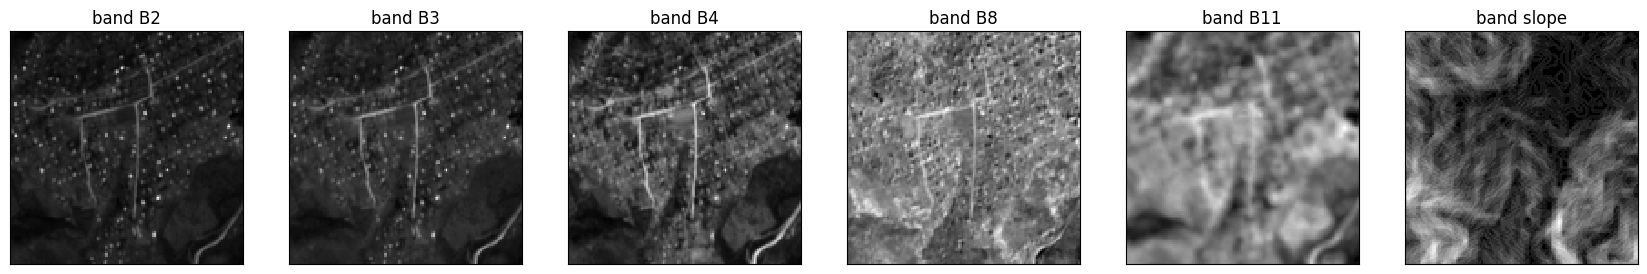

In [ ]:

from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as patches
event_id = 'id_rhg5w8vmv3ny'

num_cols = len(BAND_NAMES)
_, axes = plt.subplots(
    ncols=num_cols,
    figsize=(num_cols * 3.5, 3.5),
    facecolor='white',
)

for band_idx in range(num_cols):
  img = images[event_id][..., band_idx]
  axes[band_idx].imshow(img, cmap='gray', interpolation='nearest')
  axes[band_idx].set_title(f'band {BAND_NAMES[band_idx]}')
  axes[band_idx].get_xaxis().set_visible(False)
  axes[band_idx].get_yaxis().set_visible(False)

In [ ]:
# Split Data
rng = np.random.default_rng(seed=0xf100d)
event_ids = train_data['event_id'].unique()
new_split = pd.Series(
    data=np.random.choice(['train', 'valid'], size=len(event_ids), p=[0.9, 0.1]),
    index=event_ids,
    name='split',
)
data_new = train_data.join(new_split, on='event_id')

train_df = data_new[data_new['split'] == 'train']
train_timeseries = train_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
train_labels = train_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

valid_df = data_new[data_new['split'] == 'valid']
valid_timeseries = valid_df.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()
valid_labels = valid_df.pivot(index='event_id', columns='event_t', values='label').to_numpy()

test_timeseries = test_data.pivot(index='event_id', columns='event_t', values='precipitation').to_numpy()

event_splits = data_new.groupby('event_id')['split'].first()

In [ ]:
# Process Images
train_images, valid_images, test_images = [], [], []

for event_id in tqdm(data_new['event_id'].unique()):
    img = preprocess_image(images[event_id])
    if data_new.loc[data_new['event_id'] == event_id, 'split'].iloc[0] == 'train':
        train_images.append(img)
    else:
        valid_images.append(img)

for event_id in tqdm(test_data['event_id'].unique()):
    img = preprocess_image(images[event_id])
    test_images.append(img)

train_images = np.stack(train_images, axis=0)
valid_images = np.stack(valid_images, axis=0)
test_images = np.stack(test_images, axis=0)

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

In [ ]:
print(f'{train_timeseries.shape=}')
print(f'    {train_images.shape=}')
print(f'    {train_labels.shape=}')

train_timeseries.shape=(606, 730)
    train_images.shape=(606, 128, 128, 6)
    train_labels.shape=(606, 730)


In [ ]:
print(f'{valid_timeseries.shape=}')
print(f'    {valid_images.shape=}')
print(f'    {valid_labels.shape=}')

valid_timeseries.shape=(68, 730)
    valid_images.shape=(68, 128, 128, 6)
    valid_labels.shape=(68, 730)


In [ ]:
print(f'{test_timeseries.shape=}')
print(f'    {test_images.shape=}')


test_timeseries.shape=(224, 730)
    test_images.shape=(224, 128, 128, 6)


In [ ]:
# Dataset Preparation
def get_datasets():
    return {
        'train': {
            'timeseries': train_timeseries,
            'image': train_images,
            'label': train_labels,
        },
        'valid': {
            'timeseries': valid_timeseries,
            'image': valid_images,
            'label': valid_labels,
        },
        'test': {
            'timeseries': test_timeseries,
            'image': test_images,
        },
    }

In [ ]:
def build_model():
    image_input = tf.keras.Input(shape=(128, 128, 6), name="image")
    timeseries_input = tf.keras.Input(shape=(730,), name="timeseries")

    # Image branch
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    image_features = layers.Dense(128, activation='relu')(x)

    # Time-series branch
    y = layers.Dense(128, activation='relu')(timeseries_input)
    y = layers.Dense(128, activation='relu')(y)

    # Combined branch
    combined = layers.concatenate([image_features, y])
    z = layers.Dense(256, activation='relu')(combined)
    z = layers.Dense(730, activation='sigmoid')(z)  # Sigmoid for binary classification

    model = models.Model(inputs=[timeseries_input, image_input], outputs=z)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Load datasets
datasets = get_datasets()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Model Training
# Model Training
model = build_model()
model.fit(
    [datasets['train']['timeseries'], datasets['train']['image']],
    datasets['train']['label'],  # Ensure labels are binary (0 or 1)
    validation_data=(
        [datasets['valid']['timeseries'], datasets['valid']['image']],
        datasets['valid']['label']
    ),
    batch_size=16,
    epochs=50,
    callbacks= callbacks
)


# Prediction
#predictions = model.predict([datasets['test']['timeseries'], datasets['test']['image']])
#np.save('test_predictions.npy', predictions)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.0000e+00 - loss: 0.2857 - val_accuracy: 0.0294 - val_loss: 0.0086
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0165 - loss: 0.0061 - val_accuracy: 0.0000e+00 - val_loss: 0.0055
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0319 - loss: 0.0046 - val_accuracy: 0.0294 - val_loss: 0.0053
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0732 - loss: 0.0038 - val_accuracy: 0.0294 - val_loss: 0.0054
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1550 - loss: 0.0033 - val_accuracy: 0.0294 - val_loss: 0.0052
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2417 - loss: 0.0026 - val_accuracy: 0.0294 - val_loss: 0.0053
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3341 - loss: 0.0019 - val_accuracy: 0.0147 - val_loss: 0.0052
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4123 - loss: 0.0014 - val_accuracy: 

In [ ]:
# Predict on test set
predictions = model.predict([datasets['test']['timeseries'], datasets['test']['image']])
preds_df = pd.DataFrame(predictions.squeeze(), index=test_data['event_id'].unique())
preds_df.to_csv('predictions.csv', index=True, header=False)

print("Prediction file saved: predictions.csv")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Prediction file saved: predictions.csv


In [ ]:
# Predict on test set
probs = model.predict([datasets['test']['timeseries'], datasets['test']['image']])
print (probs.shape)

# Flatten predictions to match the expected submission format
probs_flattened = probs.flatten()

# Create submisiion file to be uploaded to Zindi for scoring
subs = pd.DataFrame({'event_id': test_data.event_id, 'label': probs_flattened})
subs.to_csv('mysubmission5.csv', index = False)

subs.head()
subs.isnull().sum()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(224, 730)


,0
event_id,0
label,0


In [ ]:
# Predict on test set
probs = model.predict([datasets['test']['timeseries'], datasets['test']['image']])
print (probs.shape)

# Flatten predictions to match the expected submission format
probs_flattened = probs.flatten()

# Load the sample submission file
BASE_PATH = '/content'
# Check if the file exists before trying to read it
if os.path.exists(BASE_PATH + '/SampleSubmission.csv'):
    sample_submission = pd.read_csv(BASE_PATH + '/SampleSubmission.csv')
else:
    # If the file doesn't exist, raise an error or handle it appropriately
    raise FileNotFoundError(f"The file 'SampleSubmission.csv' was not found in '{BASE_PATH}'. Please ensure the file exists and is in the correct location.")

# Assign the predicted probabilities to the 'label' column
sample_submission['label'] = probs_flattened

# Save the submission file
submission_path = os.path.join(BASE_PATH, 'submission11.csv')
sample_submission.to_csv(submission_path, index=False)

# Display the first few rows of the submission file
print(sample_submission.head(), )
print(f"Submission file saved to: {submission_path}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(224, 730)
              event_id     label
0  id_j7b6sokflo4k_X_0  0.000282
1  id_j7b6sokflo4k_X_1  0.000020
2  id_j7b6sokflo4k_X_2  0.000215
3  id_j7b6sokflo4k_X_3  0.000109
4  id_j7b6sokflo4k_X_4  0.000017
Submission file saved to: /content/submission11.csv
